# Exploring Financial Data using Nasdaq Data Link API

In this project, we'll integrate our skills of making API requests, extracting specific data, and transforming it into useful formats to perform practical data extraction and analysis using a financial dataset. We will use data that's being provided via the [Nasdaq Data Link API](https://docs.data.nasdaq.com/docs/in-depth-usage-1). It provides a gateway to a wide range of financial data sets, including comprehensive metrics on various companies. We will focus on the `MER/F1` datatable, which contains detailed financial information such as balance sheets, cash flow statements, and income statements.

We will extract financial data for a specific set of companies, with an emphasis on understanding their financial performance over time. We'll be looking at metrics like Accrued Expenses Turnover and exploring how these values differ among companies and regions.

**Our goal:** To perform a detailed analysis of this financial data, including trend analysis and comparative studies, We will utilize Python for data retrieval, cleaning, and analysis, and create visualizations to present our findings effectively.

## Getting familiar with the API documentation

Looking at the [Nasdaq Data Link API documentation](https://docs.data.nasdaq.com/docs/in-depth-usage-1) allows us to identify the necessary basic information about how to work with the API.

1. Base URL and main table name: `GET https://data.nasdaq.com/api/v3/datatables/{datatable_code}.{format}?<row_filter_criteria>` 
An example query is: `curl "https://data.nasdaq.com/api/v3/datatables/ETFG/FUND.json?ticker=SPY&api_key=YOURAPIKEY"`.
The above request returns those rows from the "ETFG/FUND" table whose "ticker" column has a value of "SPY". 
2. Query parameters and filterable columns:  For the ETFG/FUND table the columns `date` , `ticker`, `shares_oustanding`, `nav` and `flow_daily` are available.
3. Rate limits and guidelines: 
For authenticated users (Non-Premium) the rate limits are
- 300 calls per 10 seconds
- 2,000 calls per 10 minutes
- 50,000 calls per day
- Concurrency limit: 1 call at a time, with 1 additional call in the queue.
The Tables API allows up to 10,000 rows per call. 

To handle more data, you can paginate using the `next_cursor_id` field in the JSON response.

We are interested in the `MER/F1`table in JSON format, which can be accessed via: `https://data.nasdaq.com/api/v3/datatables/MER/F1.json`.
Optional query parameters are:
- Limit rows per request: `qopts.per_page=10`.
- Filter by 'ticker' column value 'SPY': `ticker=SPY`.
- Specify columns in the response: `qopts.columns=ticker,date,shares_outstanding`.
- Filter rows by multiple 'ticker' values: `ticker=SPY,IWM,GLD`

## Configuring the API key, loading necessary libraries and fetching a small data sample

In [1]:
# Configure and import API key
import config
api_key = config.API_KEY

# Import libraries
import requests 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Assign API URL
api_url = "https://data.nasdaq.com/api/v3/datatables/MER/F1.json"

# Creating an API parameters dictionary
parameters = {
    "api_key": api_key,
    "qopts.per_page": 10,
    }

# Fetch some sample data
response = requests.get(api_url, params=parameters)
json_data = response.json()
print(json_data)

{'datatable': {'data': [[2438, 1868192544, -1802, 10.481948, '2011-06-30', 'Q2', 'U', 'EUR', 'True', 'Deutsche Bank AG', 'Deutsche Bank AG', 'Active', 'DEU', 'Europe', 1159508, '5.1.1', 'DB', 'NYS', 'Taunusanlage 12', None, None, None, 'Frankfurt am Main', None, 'DEU', '60325', '(49) 69 910 00', '(49) 69 910 34 225', 'www.db.com', '2023-12-31', 'Accrued Expenses Turnover', 'Derived'], [2438, 1868216112, -1802, 8.161754, '2011-09-30', 'Q3', 'U', 'EUR', 'True', 'Deutsche Bank AG', 'Deutsche Bank AG', 'Active', 'DEU', 'Europe', 1159508, '5.1.1', 'DB', 'NYS', 'Taunusanlage 12', None, None, None, 'Frankfurt am Main', None, 'DEU', '60325', '(49) 69 910 00', '(49) 69 910 34 225', 'www.db.com', '2023-12-31', 'Accrued Expenses Turnover', 'Derived'], [2438, 1885063456, -1802, 10.788213, '2012-06-30', 'Q2', 'U', 'EUR', 'True', 'Deutsche Bank AG', 'Deutsche Bank AG', 'Active', 'DEU', 'Europe', 1159508, '5.1.1', 'DB', 'NYS', 'Taunusanlage 12', None, None, None, 'Frankfurt am Main', None, 'DEU', '60

From this output we can identify already some information. For example there is basic information about the companies, such as:
- Company Name: Deutsche Bank AG
- Data Points: Accrued Expenses Turnover and Cash Flow Per Share.
- Time Period: Quarterly data from 2011 to 2013.
- Currency: EUR.
- Location: Frankfurt am Main, Germany.
- Status: Active.

Common Fields: 
- `compnumber`: Company number.
- `reportid`: Report ID.
- `mapcode`: Mapping code.
- `amount`: Financial amount.
- `reportdate`: Date of the report.
- `reporttype`: Type of report (e.g., Q2, Q3).
- `currency`: Currency used.
- `company_name`: Name of the company.
- `status`: Status of the company.
- `country`: Country of the company.
- `region`: Region of the company.
- `address`: Address of the company.
- `phone`: Contact number.
- `website`: Company website.
- `data_type`: Type of data (e.g., Derived, Cash Flow).

There seems to be some redundancy in the data. For instance, Deutsche Bank AG has multiple entries for different quarters and metrics, which might seem repetitive but might be necessary for a complete time-series analysis.

From the first row we can see that for Deutsche Bank AG, in the second quarter (Q2) of 2011, the Accrued Expenses Turnover ratio was approximately 10.48. This suggests that during this quarter, Deutsche Bank effectively managed its short-term liabilities by cycling through its accrued expenses roughly 10.48 times. A high turnover ratio like this implies efficient management of short-term obligations, provided this figure aligns with industry standards and the company's norms.

The `Accrued Expenses Turnover ratio` is a financial metric that measures how efficiently a company is managing its accrued expenses. Accrued expenses are expenses that have been incurred but not yet paid. The ratio helps assess how quickly a company pays off its accrued liabilities.
The Accrued Expenses Turnover ratio is calculated as: 
`Accrued Expenses Turnover = Total Operating Expenses / Average Accrued Expenses`.

Where:
`Total Operating Expenses` is the sum of all expenses associated with running the business over a specific period, excluding non-operating expenses like taxes or interest.
`Average Accrued Expenses` is the average of the accrued expenses at the beginning and end of the period.

A higher `Accrued Expenses Turnover ratio` indicates that a company is efficiently managing and paying off its accrued expenses quickly.
A lower ratio suggests that the company might be delaying payments or not effectively managing its accrued expenses.
This ratio is particularly useful for understanding a company's short-term liabilities management and its cash flow efficiency.

## Processing the JSON Data into a DataFrame


In [2]:
# Extract column names
columns = [col['name'] for col in json_data['datatable']['columns']]

# Extract data
data = json_data['datatable']['data']

# Create DataFrame and print it
df = pd.DataFrame(data, columns=columns)
print(df)

# Get the total number of rows
print("Total Rows:", df.shape[0])


   compnumber    reportid  mapcode        amount  reportdate reporttype  \
0        2438  1868192544    -1802  1.048195e+01  2011-06-30         Q2   
1        2438  1868216112    -1802  8.161754e+00  2011-09-30         Q3   
2        2438  1885063456    -1802  1.078821e+01  2012-06-30         Q2   
3        2438  1885087024    -1802  9.437545e+00  2012-09-30         Q3   
4        2438  1901934112    -1802  8.755041e+00  2013-06-30         Q2   
5        2438  1901957680    -1802  8.109493e+00  2013-09-30         Q3   
6        2438  1901981184    -7562  7.047783e+00  2013-12-31          A   
7       17630  1851369024    -4524  1.610000e+08  2010-12-31         Q4   
8       17630  1851369024    -5917  3.440906e+00  2010-12-31         Q4   
9       17630  1868192544    -1016  2.631808e+00  2011-06-30         Q2   

  auditorstatus currency consolidated          longname  ...  \
0             U      EUR         True  Deutsche Bank AG  ...   
1             U      EUR         True  Deutsch

Now that this has worked for our small data sample, we can scale this up to 10,000 rows.

In [3]:
# Updating API parameters dictionary to fetch 10,000 rows
parameters = {
    "api_key": api_key,
    "qopts.per_page": 10000,
    }

# Fetch data
response = requests.get(api_url, params=parameters)
json_data = response.json()

# Extract column names
columns = [col['name'] for col in json_data['datatable']['columns']]

# Extract data
data = json_data['datatable']['data']

# Create DataFrame 
df_metric = pd.DataFrame(data, columns=columns)

# Get the total number of rows
print("Total Rows:", df_metric.shape[0])

# Print the first 20 entries
print(df_metric.head(20))

Total Rows: 10000
    compnumber    reportid  mapcode        amount  reportdate reporttype  \
0         2438  1868192544    -1802  1.048195e+01  2011-06-30         Q2   
1         2438  1868216112    -1802  8.161754e+00  2011-09-30         Q3   
2         2438  1885063456    -1802  1.078821e+01  2012-06-30         Q2   
3         2438  1885087024    -1802  9.437545e+00  2012-09-30         Q3   
4         2438  1901934112    -1802  8.755041e+00  2013-06-30         Q2   
5         2438  1901957680    -1802  8.109493e+00  2013-09-30         Q3   
6         2438  1901981184    -7562  7.047783e+00  2013-12-31          A   
7        17630  1851369024    -4524  1.610000e+08  2010-12-31         Q4   
8        17630  1851369024    -5917  3.440906e+00  2010-12-31         Q4   
9        17630  1868192544    -1016  2.631808e+00  2011-06-30         Q2   
10       17630  1868192544    -4524  1.208000e+09  2011-06-30         Q2   
11       17630  1868192544    -5917  2.437942e+01  2011-06-30         

## Undertanding the dataset

We have two primary aims:

- To analyze the financial trend of 'accrued expenses turnover' over a period for various companies, particularly banks.
- To examine how different regions contribute to these financial metrics.

With these aims in mind, we can start to determine which columns in our dataset will help us achieve these goals and the type of data cleaning needed for accurate analysis.

In [4]:
print(df_metric.shape)

(10000, 32)


In [5]:
print(df_metric.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   compnumber     10000 non-null  int64  
 1   reportid       10000 non-null  int64  
 2   mapcode        10000 non-null  int64  
 3   amount         10000 non-null  float64
 4   reportdate     10000 non-null  object 
 5   reporttype     10000 non-null  object 
 6   auditorstatus  9999 non-null   object 
 7   currency       10000 non-null  object 
 8   consolidated   10000 non-null  object 
 9   longname       10000 non-null  object 
 10  shortname      10000 non-null  object 
 11  status         10000 non-null  object 
 12  countrycode    10000 non-null  object 
 13  region         10000 non-null  object 
 14  cik            10000 non-null  int64  
 15  mic            10000 non-null  object 
 16  ticker         9380 non-null   object 
 17  exchange       10000 non-null  object 
 18  address

From this we can see that not all columns will be required for our analysis. We will use the `longname` of each company to identify them, and therefore don't pick the `compnumber`. The `reportid`, `reportdate` and the `reporttype`(i.e. Q1, Q2...) are important to track changes over time. The `amount` obviously contains the necessary value of an indicator that's being tracked here. The indicator itself is named in the column `indicator`, so we need these columns. As we want to see the development in different regions, we also need `country`. `statement` can help us identifying differences between reported and derived indicators. We compile a list of the columns that we need as `necessary_columns`.

In [6]:
necessary_columns=['reportid','reportdate','reporttype','amount','longname','country','region','indicator','statement']

## Filtering the DataFrame for analysis

Now that we have identified the essential columns, the next step is to refine our analysis. Recall, our primary focus is on a specific financial metric - the `accrued expenses turnover`. Our DataFrame, `df_metric`, contains various indicators, so it's important to filter for rows that specifically mention this financial metric.

In [7]:
# Selecting only necessary columns
filtered_df = df_metric[necessary_columns]

# Filter rows where indicator is 'Accrued Expenses Turnover':
filtered_df = filtered_df[filtered_df['indicator'] == 'Accrued Expenses Turnover']

In [8]:
# Inspecting the filtered data
filtered_df['indicator'].describe()

count                           139
unique                            1
top       Accrued Expenses Turnover
freq                            139
Name: indicator, dtype: object

In [9]:
filtered_df['amount'].describe()

count    139.000000
mean      26.908762
std       33.097291
min        4.689773
25%        9.675670
50%       13.753753
75%       31.777614
max      229.810427
Name: amount, dtype: float64

We can see that there are 139 unique entries for the `Accrued Expenses Turnover`. The range of this metric is enormous. On average the AET is 26.91, with a standard deviation of 33.10. As the arithmetic mean is higher than the median (13.75), we can see that there are companies with very high values of AET, driving the mean up. Generally it seems that it might be easier to identify low-performers than high performers on this metric (say the lowest quartile), as the overall level of AET is high. (And companies have an incentive to report high AETs).

This variation also signifies diverse financial management strategies among companies and suggests substantial differences in how companies manage their short-term liabilities, influenced by factors like industry and company size. 

## Enhancing the DataFrame

Enhancing the readability and information quality of our DataFrame is crucial for clear analysis and reporting. We will focus on two enhancements: adding a column with full country names and cleaning up the column names.

1. Full Country Names: The current country column uses abbreviations, which might not be immediately recognizable. Including full country names makes the data more understandable and accessible, especially for those unfamiliar with country codes.

2. Column Name Cleaning: Using consistent naming conventions, like snake_case, improves code readability and maintainability. Renaming 'longname' to 'company_name' makes the purpose of the column clearer.


In [10]:
print(filtered_df['country'].unique())

['DEU' 'BHS' 'GBR' 'JPN' 'CYM' 'USA' 'IRL']


In [11]:
# Dictionary to map country abbreviations to full names
country_mapping = {
    'USA': 'United States of America',
    'DEU': 'Germany',
    'JPN': 'Japan',
    'CYM': 'Cayman Islands',
    'BHS': 'Bahamas',
    'IRL': 'Ireland'
}

# Define a function to rename the country column
def rename_column(df, column_name, mapping_dict):
    # Map the values of the specified column using the provided dictionary
    df[column_name] = df[column_name].map(mapping_dict)
    return df[column_name]

# Applying the function to rename the 'country' column
filtered_df['country_name'] = rename_column(filtered_df, 'country', country_mapping)
print(filtered_df['country_name'].head())

0    Germany
1    Germany
2    Germany
3    Germany
4    Germany
Name: country_name, dtype: object


Now we rename the columns according to `snake_case`naming convention.

In [12]:
print(filtered_df.columns)

Index(['reportid', 'reportdate', 'reporttype', 'amount', 'longname', 'country',
       'region', 'indicator', 'statement', 'country_name'],
      dtype='object')


In [13]:
filtered_df.columns=['report_id','report_date','report_type',
                   'amount','company_name','country','region',
                   'indicator','statement','country_name']
updated_df=filtered_df.copy()
updated_df['country_name'].value_counts()

United States of America    31
Japan                       27
Cayman Islands              27
Ireland                     25
Bahamas                     19
Germany                      6
Name: country_name, dtype: int64

## Understanding financial trends over time

In business analysis and decision-making, understanding the evolution of certain financial metrics over time is crucial. This insight allows analysts and decision-makers to identify patterns, assess the health and performance of the business, and make informed predictions about future trends. Focusing on a specific time period enables analysts to conduct a more detailed and relevant analysis, as different periods can exhibit varying trends due to factors such as market conditions, seasonal effects, or company-specific events. We will now concentrate on extracting relevant data for a specific time period(2010-2015) and visualizing these trends. 

In [16]:
# Convert 'report_date' to datetime and filter for 2010-2015
updated_df['report_date'] = pd.to_datetime(updated_df['report_date'])
updated_df = updated_df[(updated_df['report_date'].dt.year >= 2010) & (updated_df['report_date'].dt.year <= 2015)]

# pick relevant columns
relevant_data = updated_df[['company_name', 'report_date', 'amount']]

Now we can plot time trends in `Accrued Expenses Turnover ratio`.

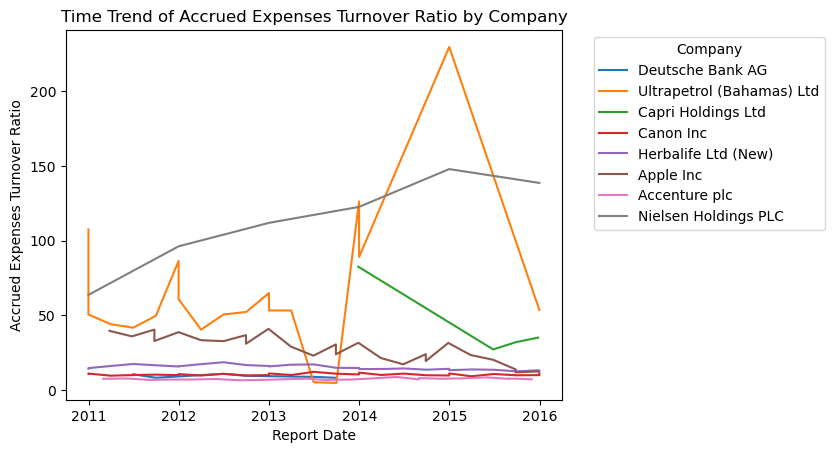

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

for company in relevant_data['company_name'].unique():
    company_data = relevant_data[relevant_data['company_name'] == company]
    
    plt.plot(company_data['report_date'], company_data['amount'], label=company)
    
plt.ylabel('Accrued Expenses Turnover Ratio')
plt.xlabel('Report Date')
plt.title('Time Trend of Accrued Expenses Turnover Ratio by Company (2010-2015)')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.show()


The plot shows an interesting pattern for 3-4 companies with on average very high AETs. Remarkable is the trend for Ultrapetrol (Bahamas) Ltd, peakin strongly in 2015, then falling dramatically. This looks a bit suspicious and could point to accounting tricks, maybe. Additionally, the jaggedness of the trend might indicate that changes occur rather abruptly and not smoothly, as in the other cases. Apart from that, Herbalife Ltd (New) seems to steadily improve its AET, with the trendlines for the other companies (at least on this scale) appearing fairly stable.

## Geographical region analysis

After successfully visualizing financial trends over time, we now shift our focus to analyzing data based on geographical regions. This involves grouping data to understand how different regions contribute to the financial metrics.

Understanding the performance of different geographical regions and stock exchanges is crucial in global financial analysis. It allows us to identify which regions are performing well and which ones may need more attention or investment. 

First, we will plot the data by geographical regions and then visualize these differences.

In [20]:
# Grouping data by country and calculating the average of the 'amount'
country_avg = updated_df.groupby('country_name')['amount'].mean()

Now we plot.

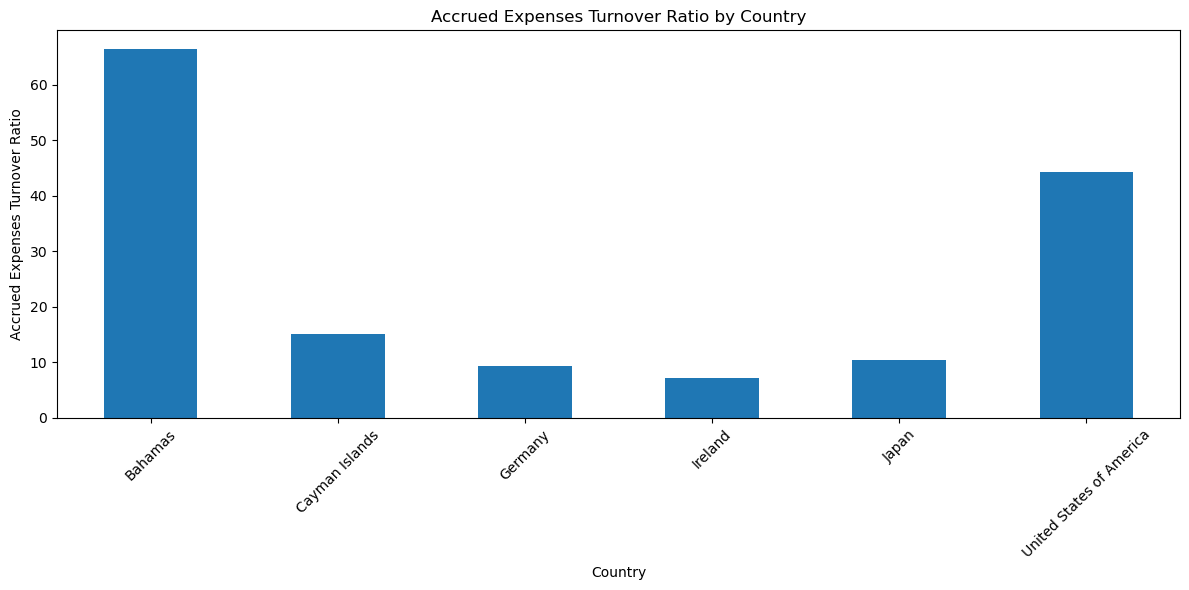

In [23]:
plt.figure(figsize=(12, 6))
country_avg.plot(kind='bar')
plt.ylabel('Accrued Expenses Turnover Ratio')
plt.xlabel('Country')
plt.title('Accrued Expenses Turnover Ratio by Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The interesting observation here is that countries like the Bahamas and the Cayman Islands, which are known as tax havens, have comparatively high AETs, as well as the US. In comparison, Germany, Ireland and Japan have comparatively low AETs. Whether these statistics show that companies in the Bahamas, Cayman Islands and the US are overall more financially solid, is not entirely clear based on this data. As we saw in the time trend analysis, the trend for some companies registered in tax havens seem very discontinous and might point to accounting tricks. As so often, more research is needed!